Custom plots related to ENSO regression focused on specific seasons and extratropical teleconnections.

In [1]:
from collections import namedtuple
from utils import get_beaker_dataset_variables
from constants import SECONDS_PER_DAY #, ENSO_DEEP_DIVE
import xarray as xr
from fme.ace.aggregator.inference.enso.historical_index import NINO34_INDEX
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['figure.dpi'] = 300
import yaml
from typing import Mapping

/opt/homebrew/Caskroom/miniconda/base/envs/fme/lib/python3.11/site-packages/earth2grid/healpix.py:60: UserWarning: healpixpad_cuda module not available, reverting to CPU for all padding routines
  warnings.warn("healpixpad_cuda module not available, reverting to CPU for all padding routines")


In [2]:
WANDB_ID_FILE = "./wandb_ids.yaml"

with open(WANDB_ID_FILE, "r") as f:
    wandb_ids = yaml.safe_load(f)

In [3]:
ENSO_DEEP_DIVE = {
    "10yr": {
        "ACE2-ERA5": {
            "IC0": wandb_ids["era5-co2-10yr-RS2-IC0-monthly-output"],
            "IC1": wandb_ids["era5-co2-10yr-RS2-IC1-monthly-output"],
            "IC2": wandb_ids["era5-co2-10yr-RS2-IC2-monthly-output"],
        },
        "ACE2-SHiELD": {
            "IC0": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC0-monthly"],
            "IC1": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC1-monthly"],
            "IC2": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC2-monthly"],
        },
    },
    "81yr": {
        "ACE2-ERA5": {
            "IC0": wandb_ids["era5-co2-81yr-RS2-IC0-monthly-output"],
        },
        "ACE2-SHiELD": {
            "IC0": wandb_ids["shield-amip-1deg-ace2-inference-81yr-IC0-monthly"],
        },
    },
}

In [4]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

EVAL_VARS = [
    EvalVar("PRATEsfc", "surface precipitation", "mm/day", SECONDS_PER_DAY),
    EvalVar("h500", "500hPa geopotential height", "m", 1.0),
    EvalVar("TMP2m", "2m air temperature", "K", 1.0),
    EvalVar("northward_wind_3", "northward wind at level 3", "m/s", 1.0),
]
DS_VARS = [var.name for var in EVAL_VARS] + ["counts"]

In [5]:
NINO34_INDEX

[((1940, 1, 1), 1.013),
 ((1940, 4, 1), 0.696),
 ((1940, 7, 1), 0.549),
 ((1940, 10, 1), 0.338),
 ((1941, 1, 1), 1.028),
 ((1941, 4, 1), 0.903),
 ((1941, 7, 1), 0.642),
 ((1941, 10, 1), 0.733),
 ((1942, 1, 1), 0.582),
 ((1942, 4, 1), 0.403),
 ((1942, 7, 1), -0.208),
 ((1942, 10, 1), -0.696),
 ((1943, 1, 1), -0.574),
 ((1943, 4, 1), -0.308),
 ((1943, 7, 1), 0.146),
 ((1943, 10, 1), -0.101),
 ((1944, 1, 1), -0.023),
 ((1944, 4, 1), -0.012),
 ((1944, 7, 1), -0.062),
 ((1944, 10, 1), -0.193),
 ((1945, 1, 1), -0.311),
 ((1945, 4, 1), -0.425),
 ((1945, 7, 1), -0.364),
 ((1945, 10, 1), -0.334),
 ((1946, 1, 1), -0.299),
 ((1946, 4, 1), -0.091),
 ((1946, 7, 1), 0.347),
 ((1946, 10, 1), 0.197),
 ((1947, 1, 1), 0.298),
 ((1947, 4, 1), 0.136),
 ((1947, 7, 1), 0.013),
 ((1947, 10, 1), -0.319),
 ((1948, 1, 1), 0.424),
 ((1948, 4, 1), 0.525),
 ((1948, 7, 1), 0.313),
 ((1948, 10, 1), 0.092),
 ((1949, 1, 1), 0.253),
 ((1949, 4, 1), 0.191),
 ((1949, 7, 1), -0.107),
 ((1949, 10, 1), -0.272),
 ((1950, 1, 

In [6]:
def load(runs: Mapping[str, Mapping[str, str]]) -> xr.Dataset:
    """
    Load the dataset from the given runs.
    """
    datasets = []
    for group_name, group_runs in runs.items():
        for ic_name, ic_run in group_runs.items():
            if "-" in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([group_name, ic_name])
            print(f"Getting dataset for run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'monthly_mean_predictions.nc', DS_VARS).drop_vars("counts")
            target_dataset = get_beaker_dataset_variables(ic_run, 'monthly_mean_target.nc', DS_VARS).drop_vars("counts")
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    ic_dataset[var.name] = var.conversion_factor * ic_dataset[var.name]
                    target_dataset[var.name] = var.conversion_factor * target_dataset[var.name]
            common_dims = {'group': [group_name], 'IC': [ic_name]}
            datasets.append(ic_dataset.expand_dims(common_dims | {'source': ['prediction']}))
            datasets.append(target_dataset.expand_dims(common_dims | {'source': ['target']}))
    return xr.merge(datasets).squeeze()

In [7]:
monthly_ds_10yr = load(ENSO_DEEP_DIVE['10yr'])
monthly_ds_10yr = monthly_ds_10yr.isel(time=slice(0, 120))  # drop empty last 2 months

Getting dataset for run: full_key='ACE2-ERA5/IC0'


Output()

Output()

Getting dataset for run: full_key='ACE2-ERA5/IC1'


Output()

Output()

Getting dataset for run: full_key='ACE2-ERA5/IC2'


Output()

Output()

Getting dataset for run: full_key='ACE2-SHiELD/IC0'


Output()

Output()

Getting dataset for run: full_key='ACE2-SHiELD/IC1'


Output()

Output()

Getting dataset for run: full_key='ACE2-SHiELD/IC2'


Output()

Output()

In [8]:
monthly_ds_10yr

<xarray.Dataset> Size: 1GB
Dimensions:           (time: 120, lat: 180, lon: 360, group: 2, IC: 3, source: 2)
Coordinates:
  * time              (time) int64 960B 0 1 2 3 4 5 ... 114 115 116 117 118 119
  * lat               (lat) float32 720B -89.24 -88.25 -87.25 ... 88.25 89.24
  * lon               (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * group             (group) object 16B 'ACE2-ERA5' 'ACE2-SHiELD'
  * IC                (IC) object 24B 'IC0' 'IC1' 'IC2'
  * source            (source) object 16B 'prediction' 'target'
    init_time         datetime64[ns] 8B 2001-01-01
    valid_time        (time) datetime64[ns] 960B 2001-01-15 ... 2010-12-15
Data variables:
    PRATEsfc          (group, IC, source, time, lat, lon) float32 373MB 0.065...
    h500              (group, IC, source, time, lat, lon) float32 373MB 5.097...
    TMP2m             (group, IC, source, time, lat, lon) float32 373MB 243.8...
    northward_wind_3  (group, IC, source, time, lat, lon) float32 373MB -1.73...

In [ ]:
monthly_ds_81yr = load(ENSO_DEEP_DIVE['81yr'])
monthly_ds_81yr = monthly_ds_81yr.isel(time=slice(None, -3))  # drop empty last 3 months

In [ ]:
monthly_ds_81yr 

In [9]:
clim = monthly_ds_10yr.set_xindex('valid_time').sel(valid_time=slice('1990', '2020')).groupby('valid_time.month').mean()

In [20]:
monthly_anomaly_10yr = monthly_ds_10yr.groupby("valid_time.month") - clim

In [23]:
seasonal_ds = monthly_anomaly_10yr.rolling(time=3, center=True).mean().isel(time=slice(None, None, 3))

In [24]:
el_nino_seasons = [x[0] for x in NINO34_INDEX if x[1]>= 0.5]
la_nina_seasons = [x[0] for x in NINO34_INDEX if x[1]<= -0.5]
el_nino_seasons = [np.datetime64(f'{x[0]}-{x[1]:02d}-15') for x in el_nino_seasons]
la_nina_seasons = [np.datetime64(f'{x[0]}-{x[1]:02d}-15') for x in la_nina_seasons]
len(el_nino_seasons), len(la_nina_seasons)

(52, 51)

In [25]:
nino_mean = []
nina_mean = []
for i_time in range(seasonal_ds.sizes["time"]):
    data = seasonal_ds.isel(time=i_time)
    if data.valid_time in el_nino_seasons:
        nino_mean.append(data)
    elif data.valid_time in la_nina_seasons:
        nina_mean.append(data)
nino_mean = xr.concat(nino_mean, dim='time').mean(dim='time')
nina_mean = xr.concat(nina_mean, dim='time').mean(dim='time')


In [26]:
diff = nino_mean - nina_mean

In [27]:
def plot_maps_ic(da, **kwargs):
    fg = da.plot(row='group', col='IC', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)}, **kwargs)
    fg.map(lambda: plt.gca().coastlines(linewidth=0.5, color='grey'))
    fig = fg.fig
    fig.set_size_inches(11, 4)

def plot_maps(da, **kwargs):
    fg = da.plot(row='source', col='group', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)}, **kwargs)
    fg.map(lambda: plt.gca().coastlines(linewidth=0.5, color='grey'))
    fig = fg.fig
    fig.set_size_inches(7, 3.8)
    
    

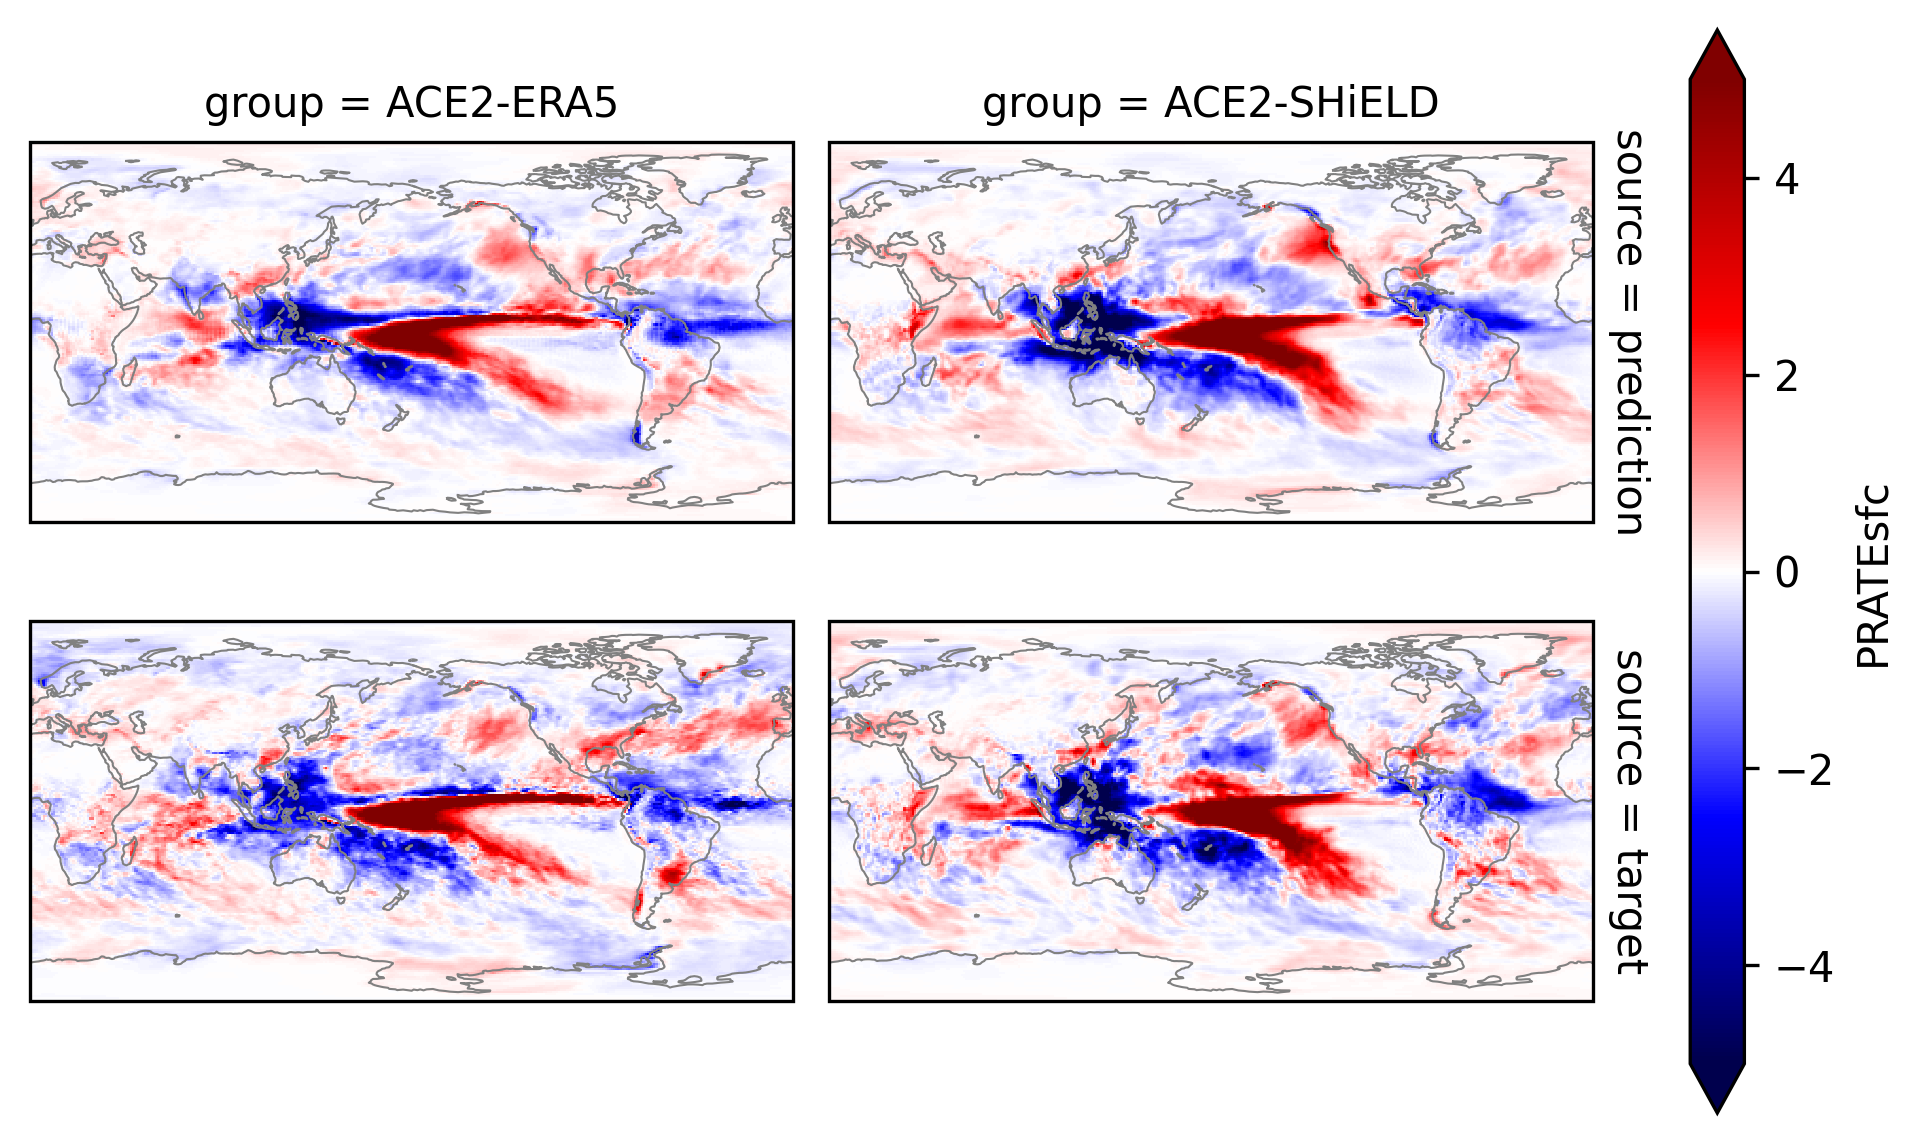

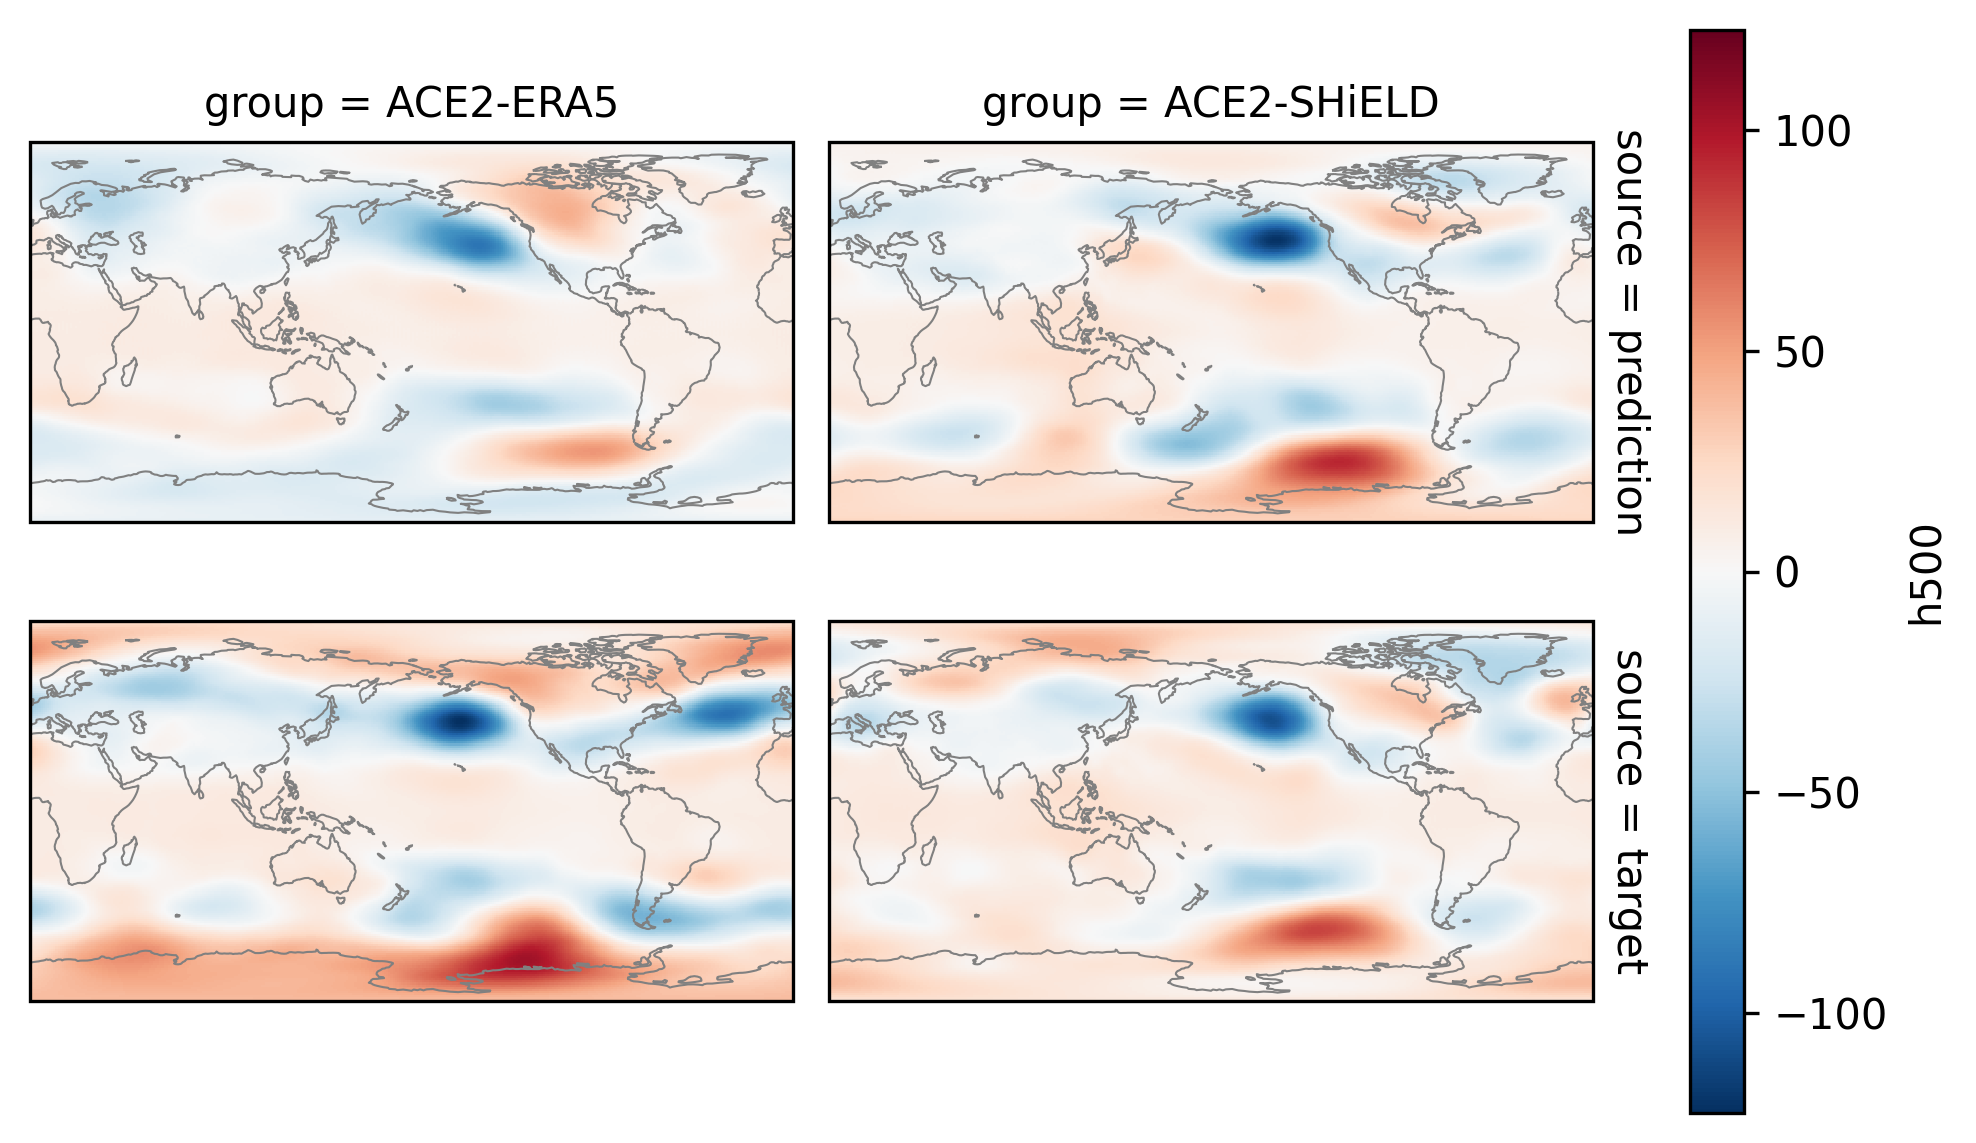

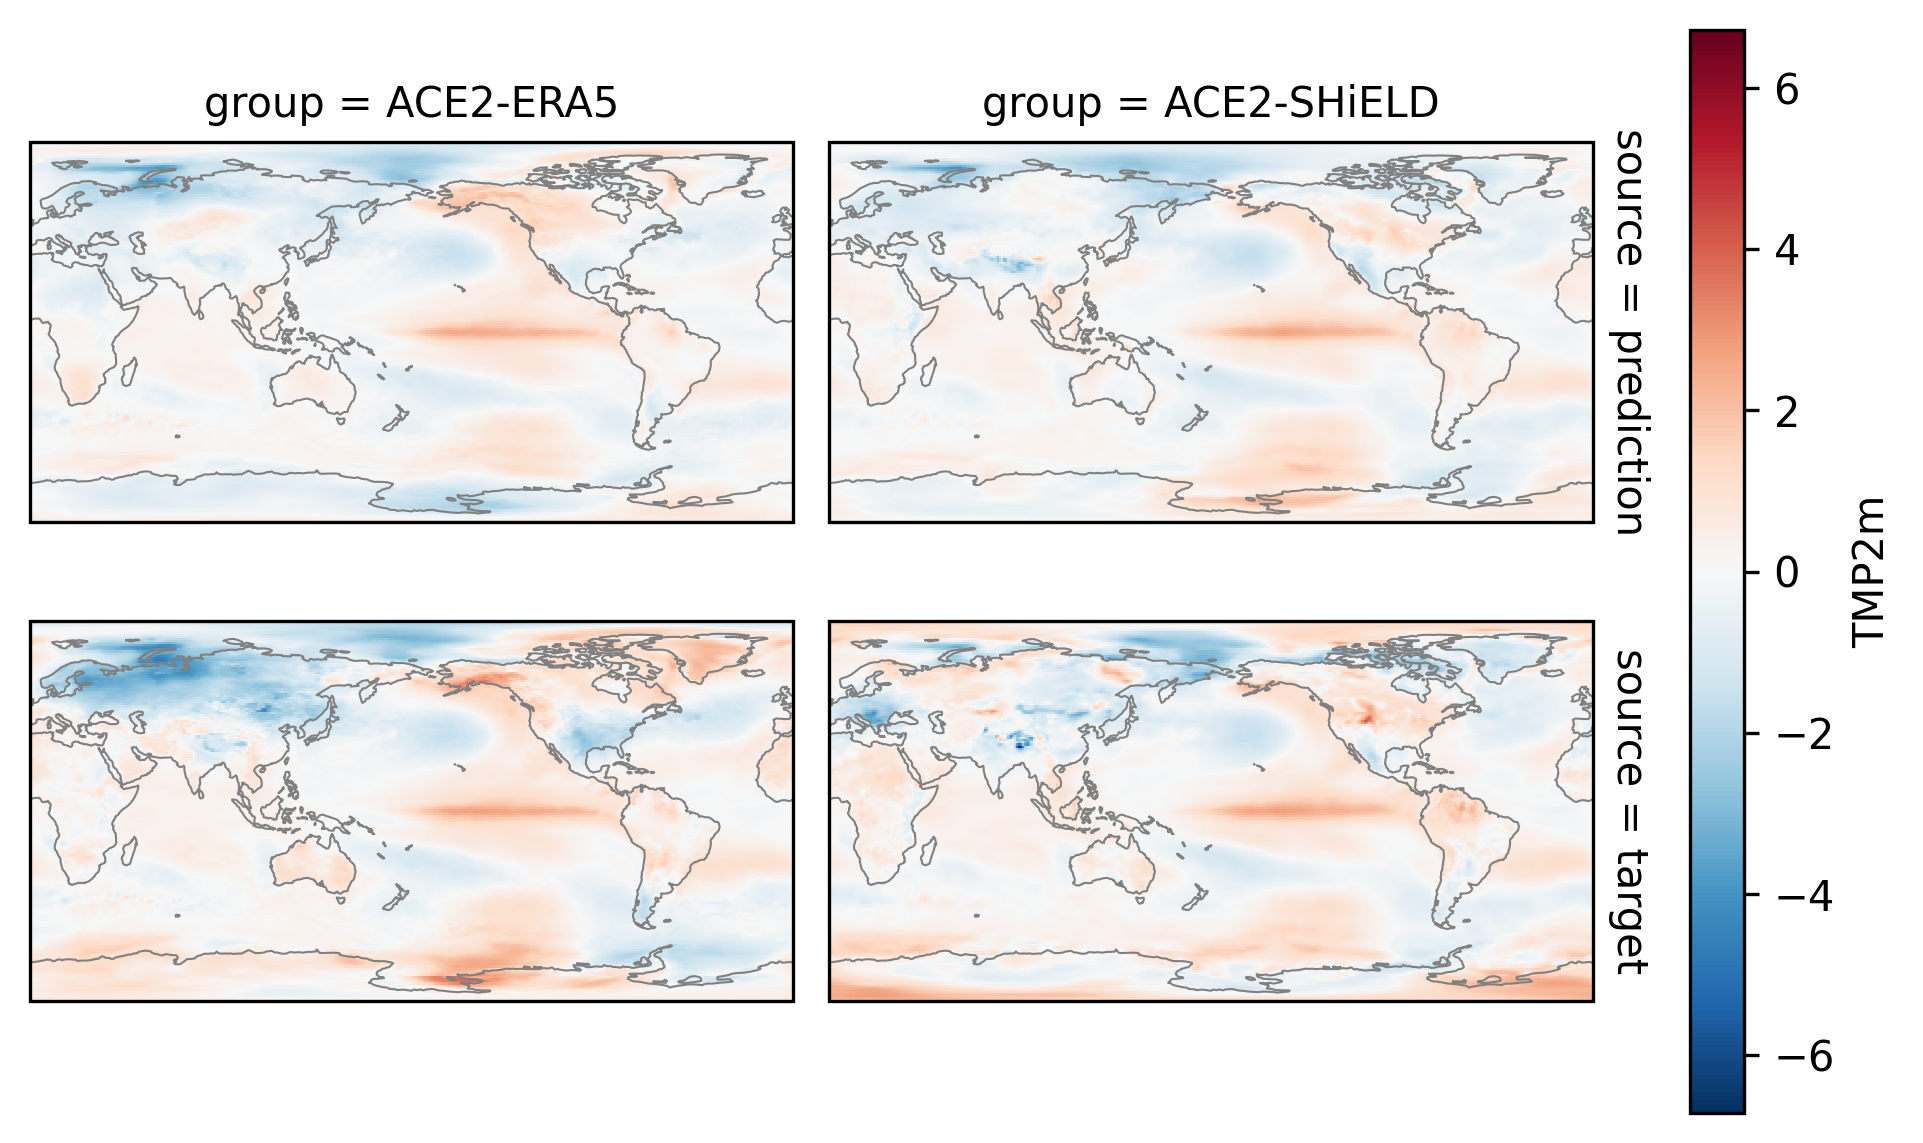

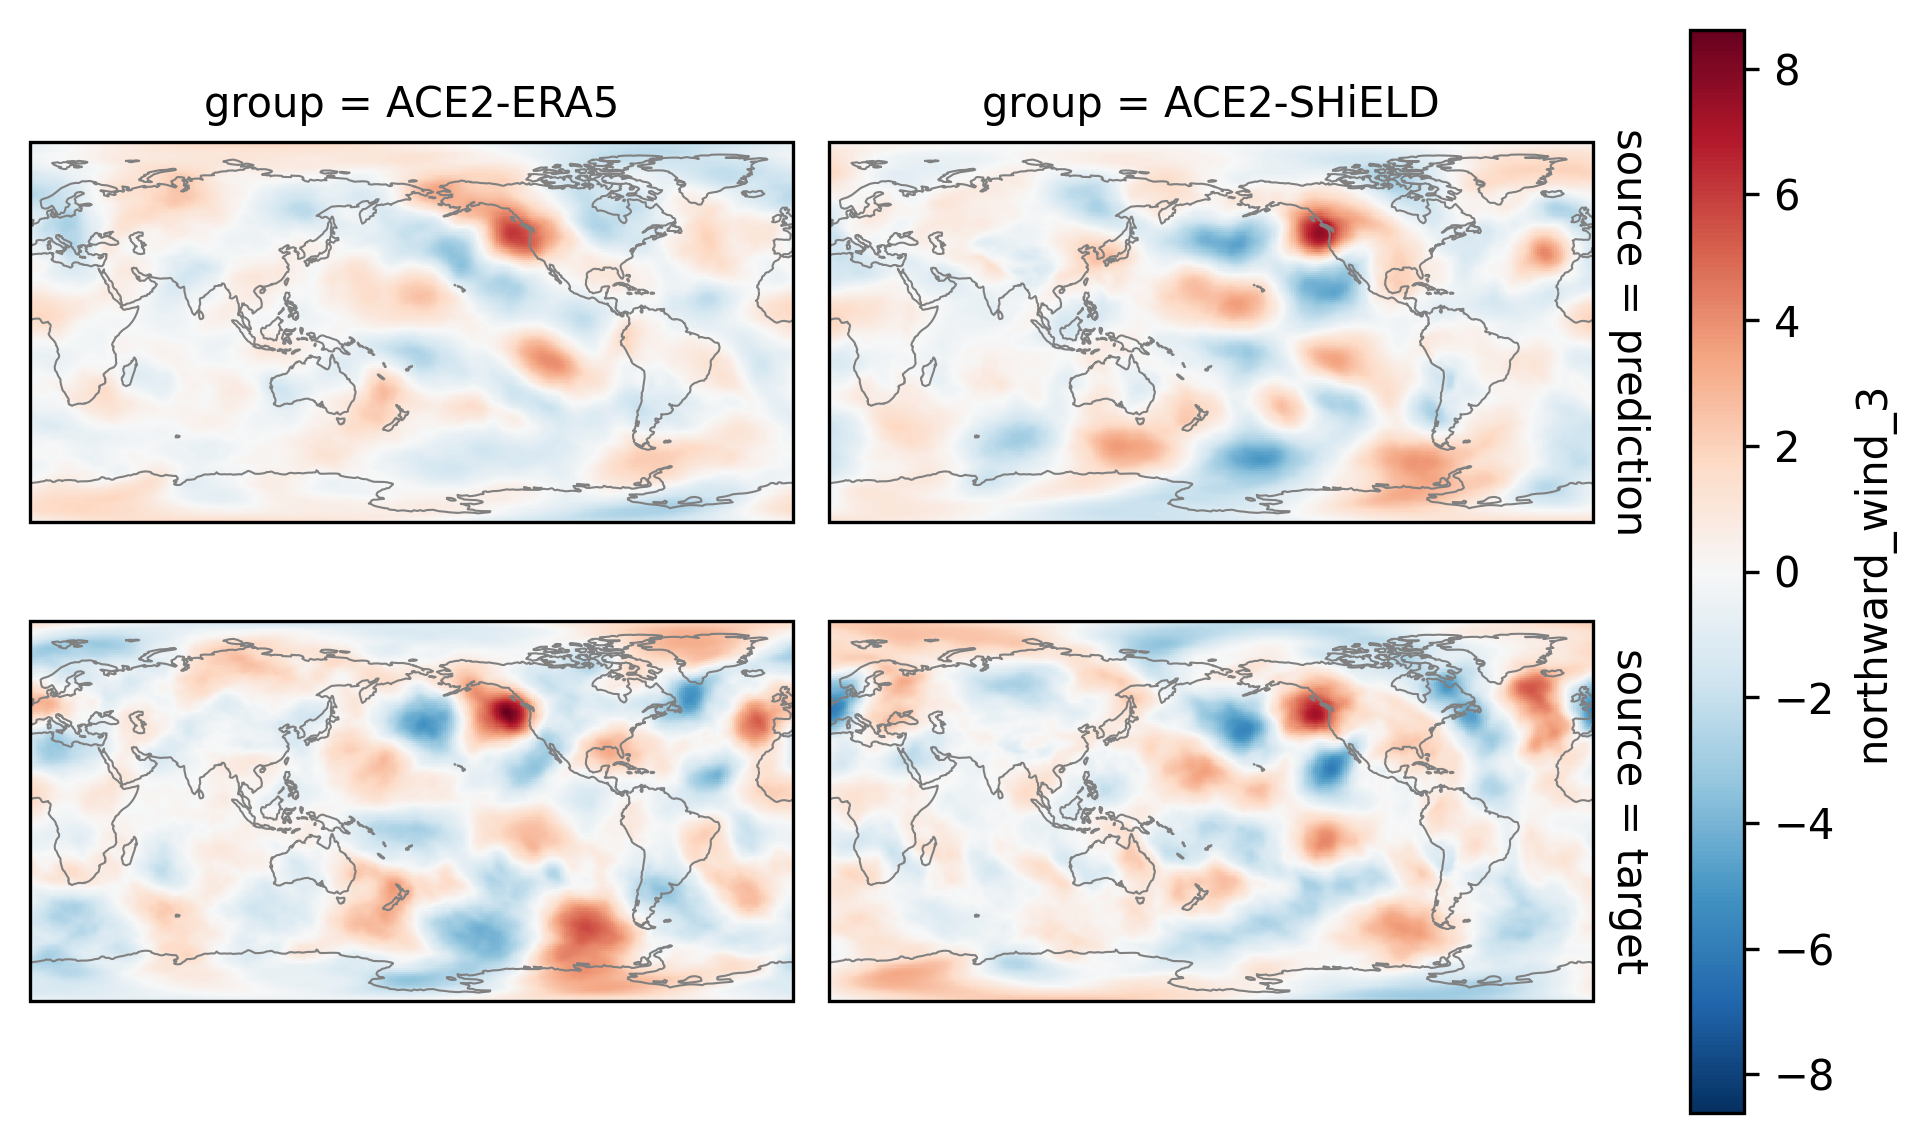

In [29]:
for var in diff.data_vars:
    if var == 'counts':
        continue
    if var == 'PRATEsfc':
        kwargs = {'vmin': -5, 'vmax': 5, 'cmap': 'seismic'}
    else:
        kwargs = {}
    
    plot_maps(diff[var].mean('IC'), **kwargs)

In [31]:
diff

<xarray.Dataset> Size: 12MB
Dimensions:           (lat: 180, lon: 360, group: 2, IC: 3, source: 2)
Coordinates:
  * lat               (lat) float32 720B -89.24 -88.25 -87.25 ... 88.25 89.24
  * lon               (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * group             (group) object 16B 'ACE2-ERA5' 'ACE2-SHiELD'
  * IC                (IC) object 24B 'IC0' 'IC1' 'IC2'
  * source            (source) object 16B 'prediction' 'target'
    init_time         datetime64[ns] 8B 2001-01-01
Data variables:
    PRATEsfc          (group, IC, source, lat, lon) float32 3MB 0.177 ... 0.0...
    h500              (group, IC, source, lat, lon) float32 3MB 22.98 ... 14.27
    TMP2m             (group, IC, source, lat, lon) float32 3MB 1.995 ... 1.292
    northward_wind_3  (group, IC, source, lat, lon) float32 3MB -1.875 ... 1.944

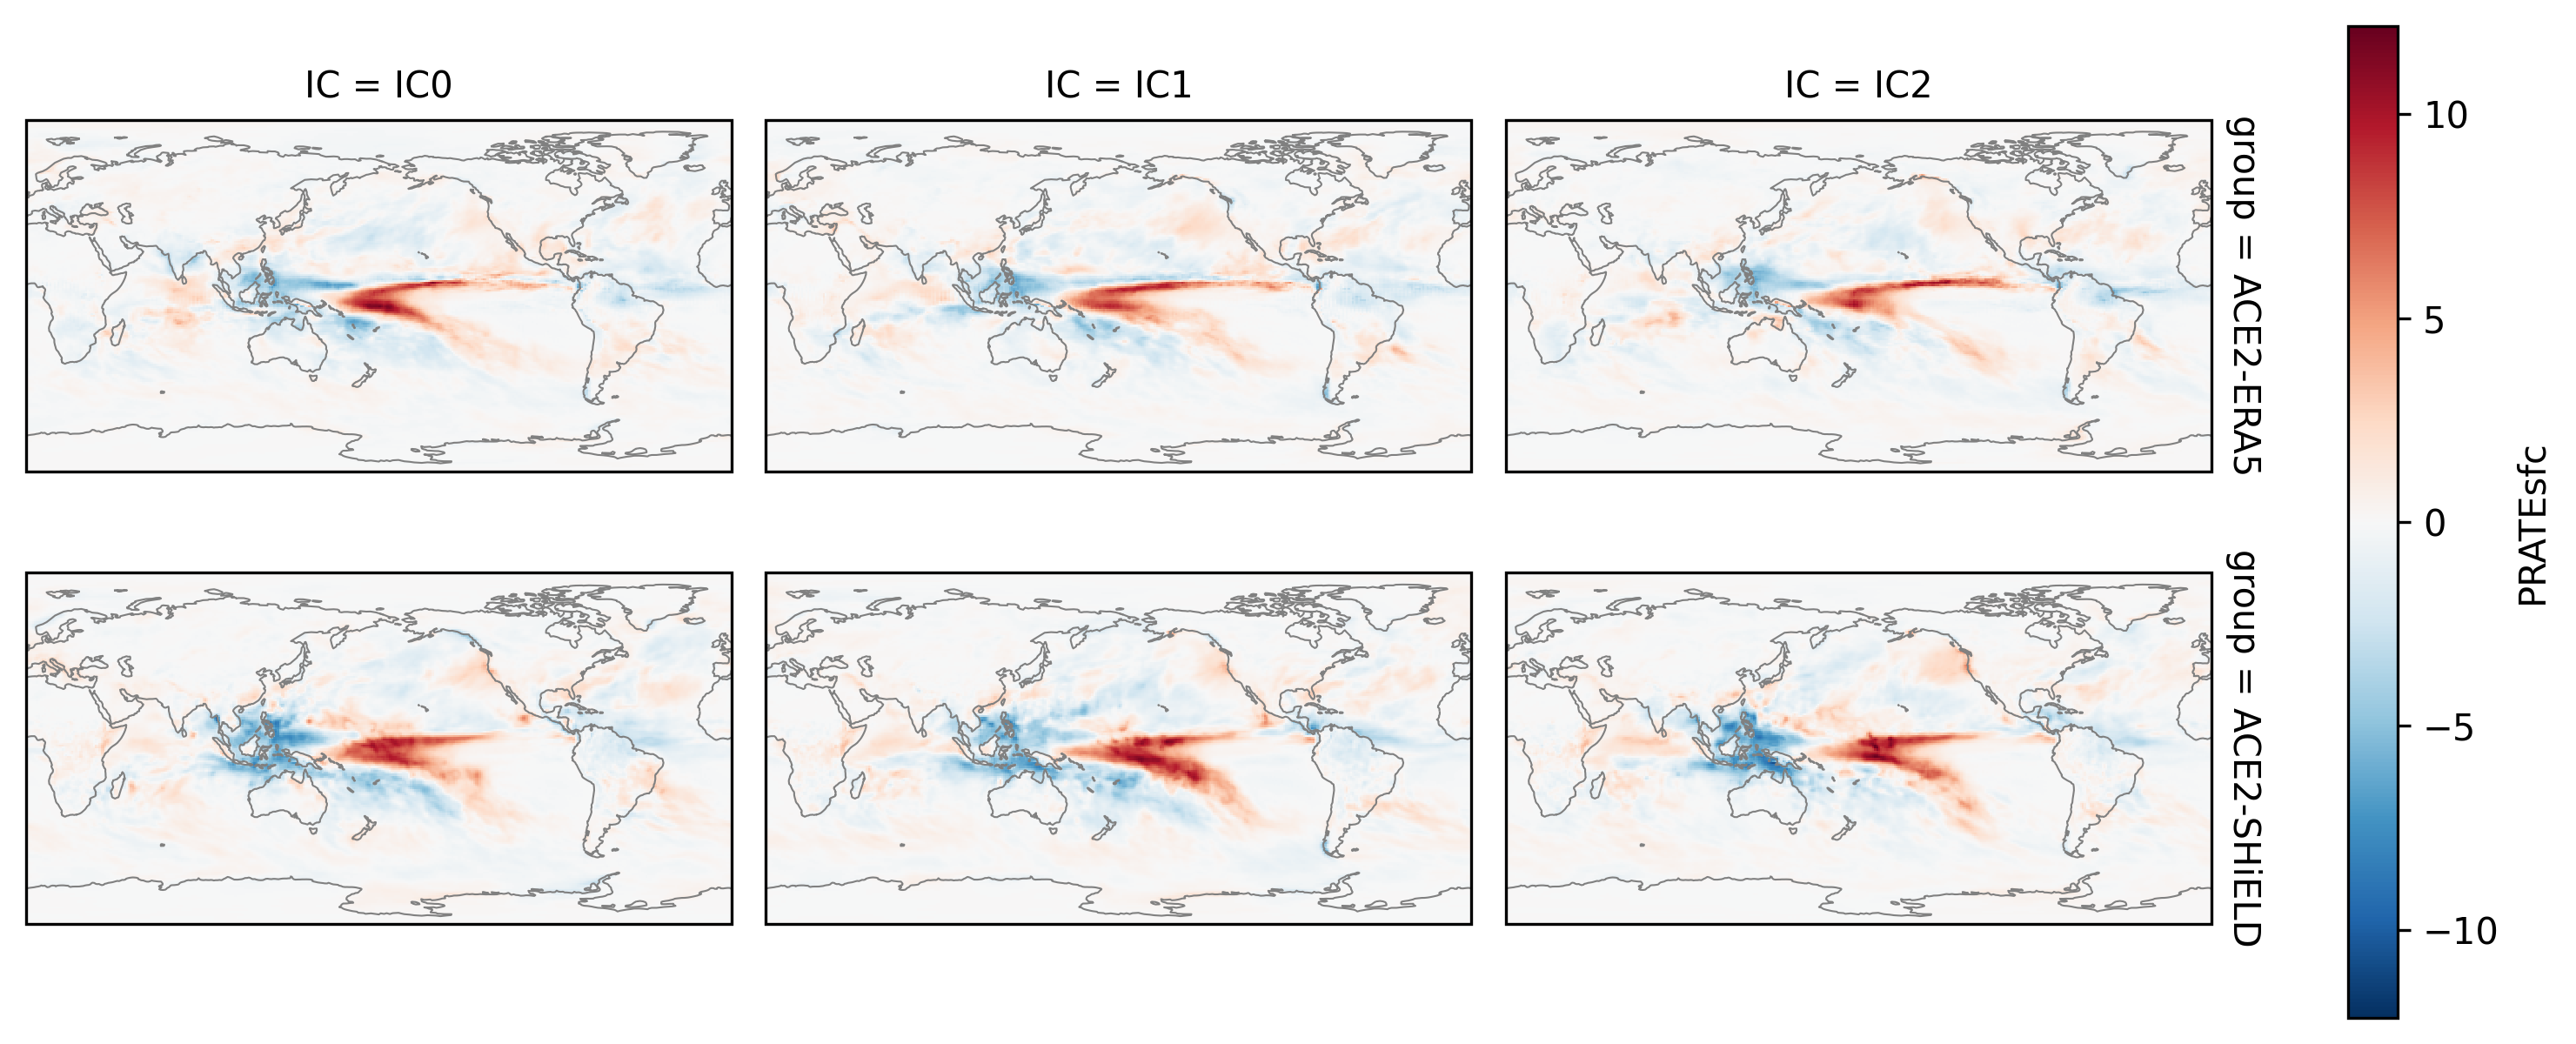

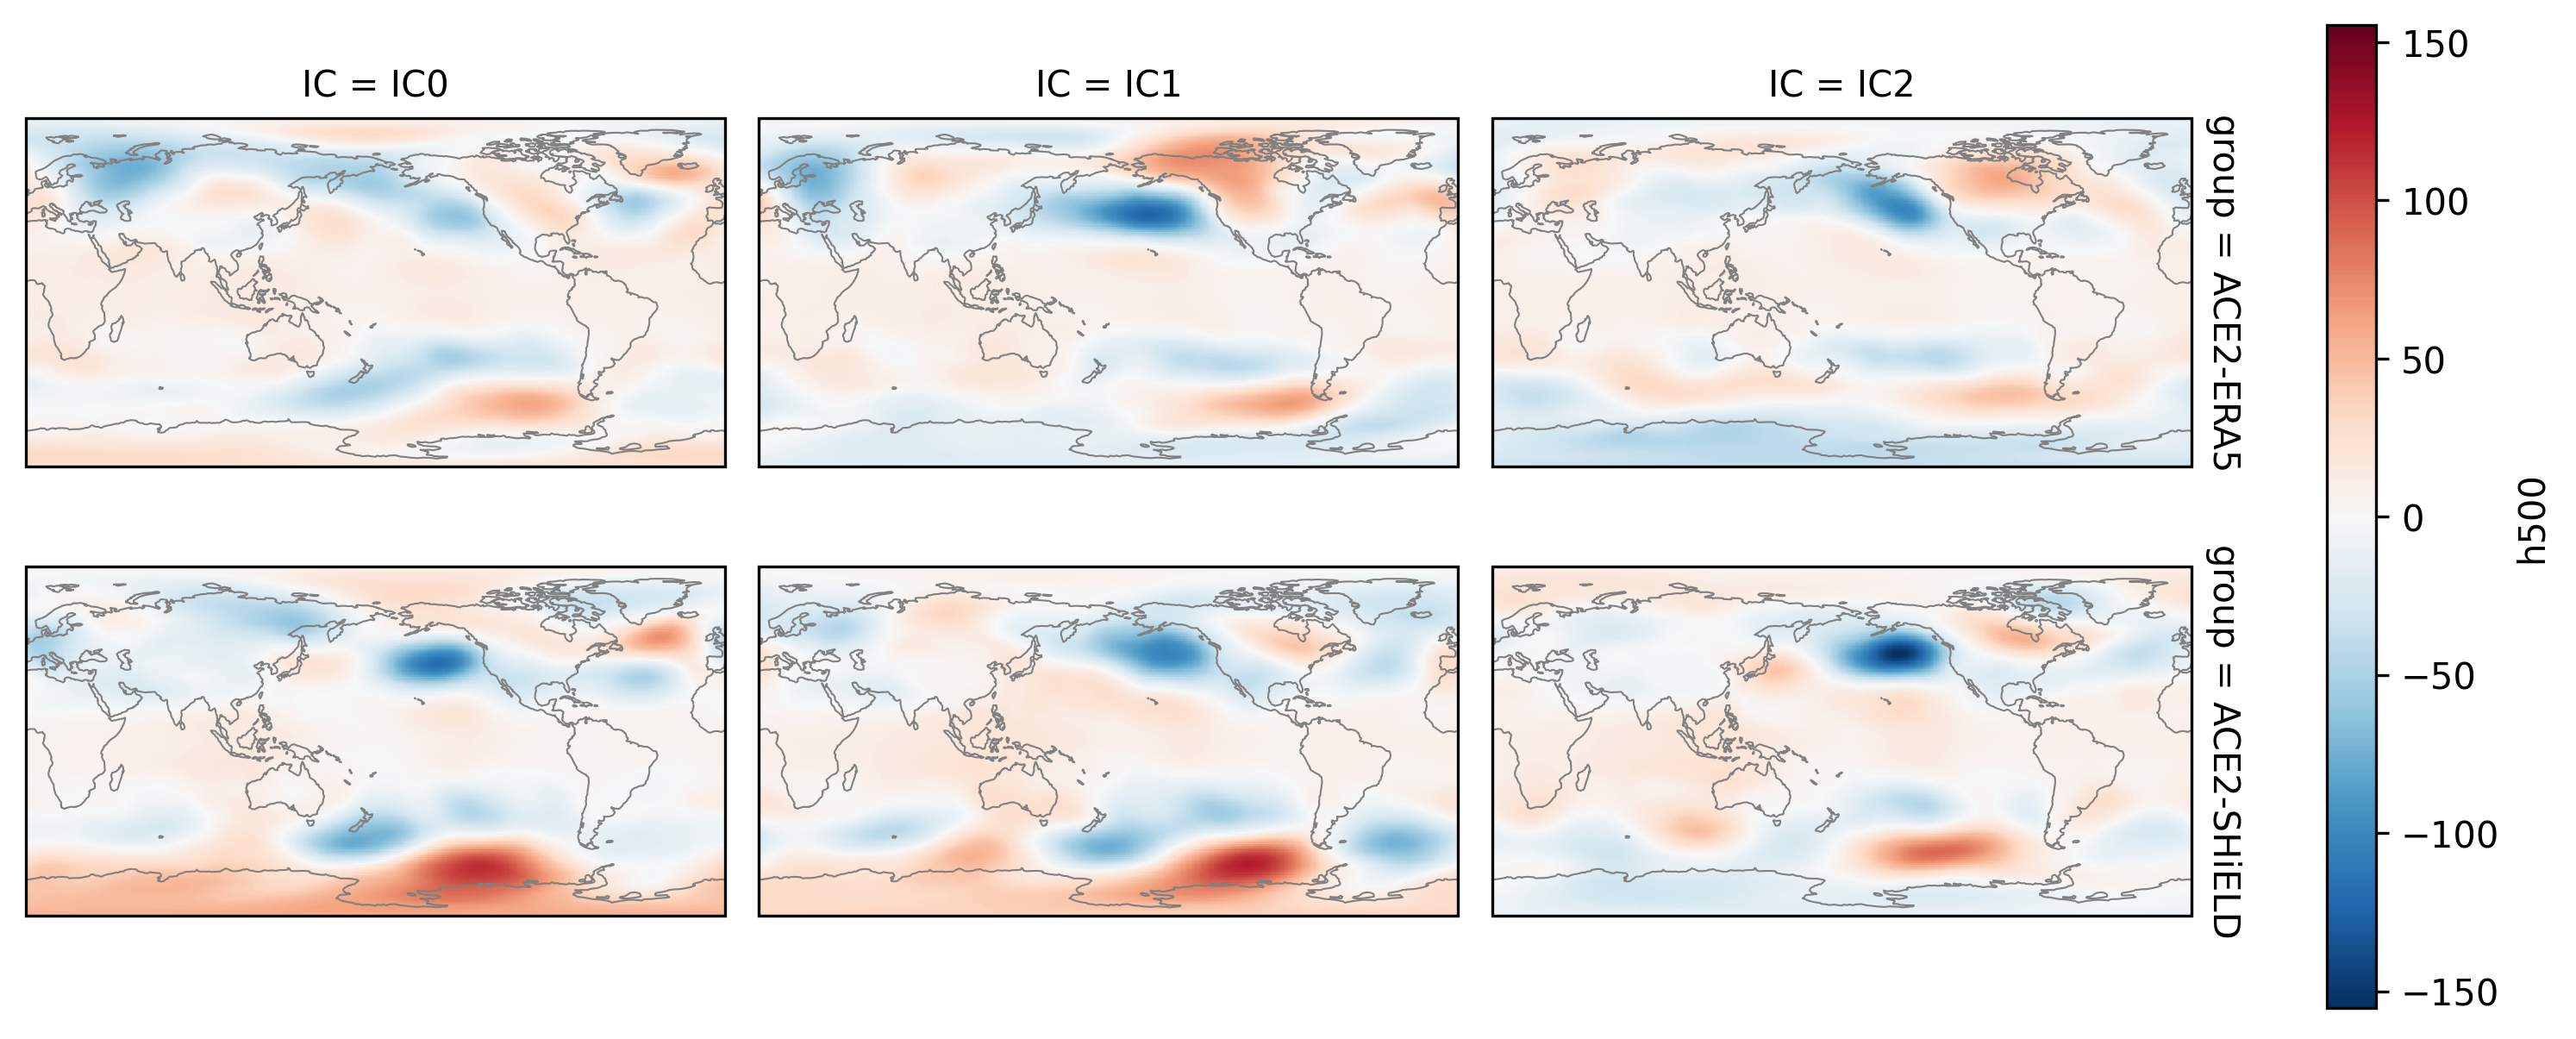

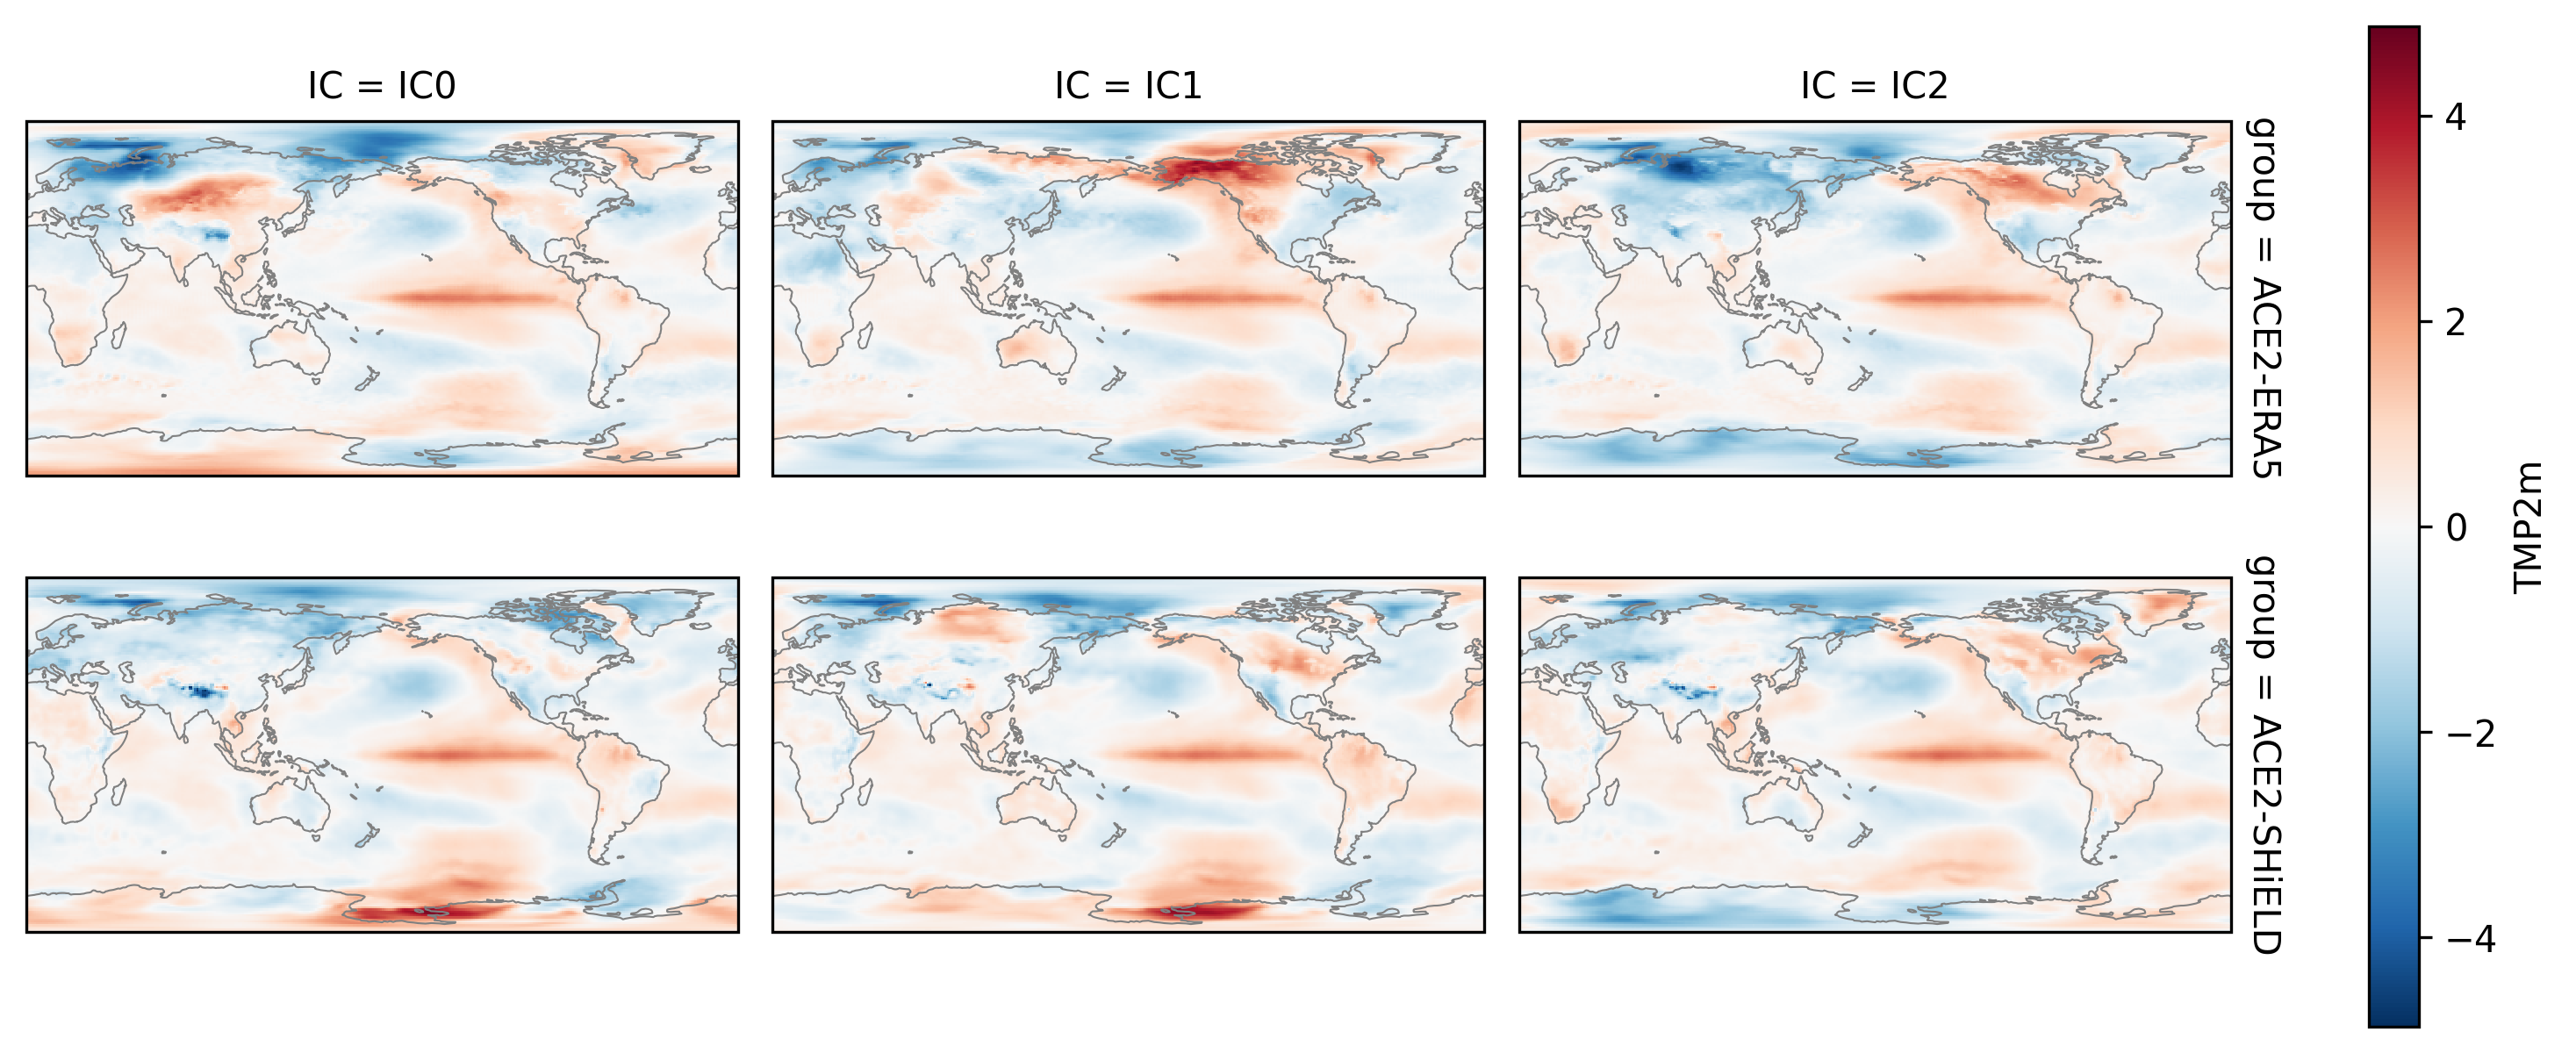

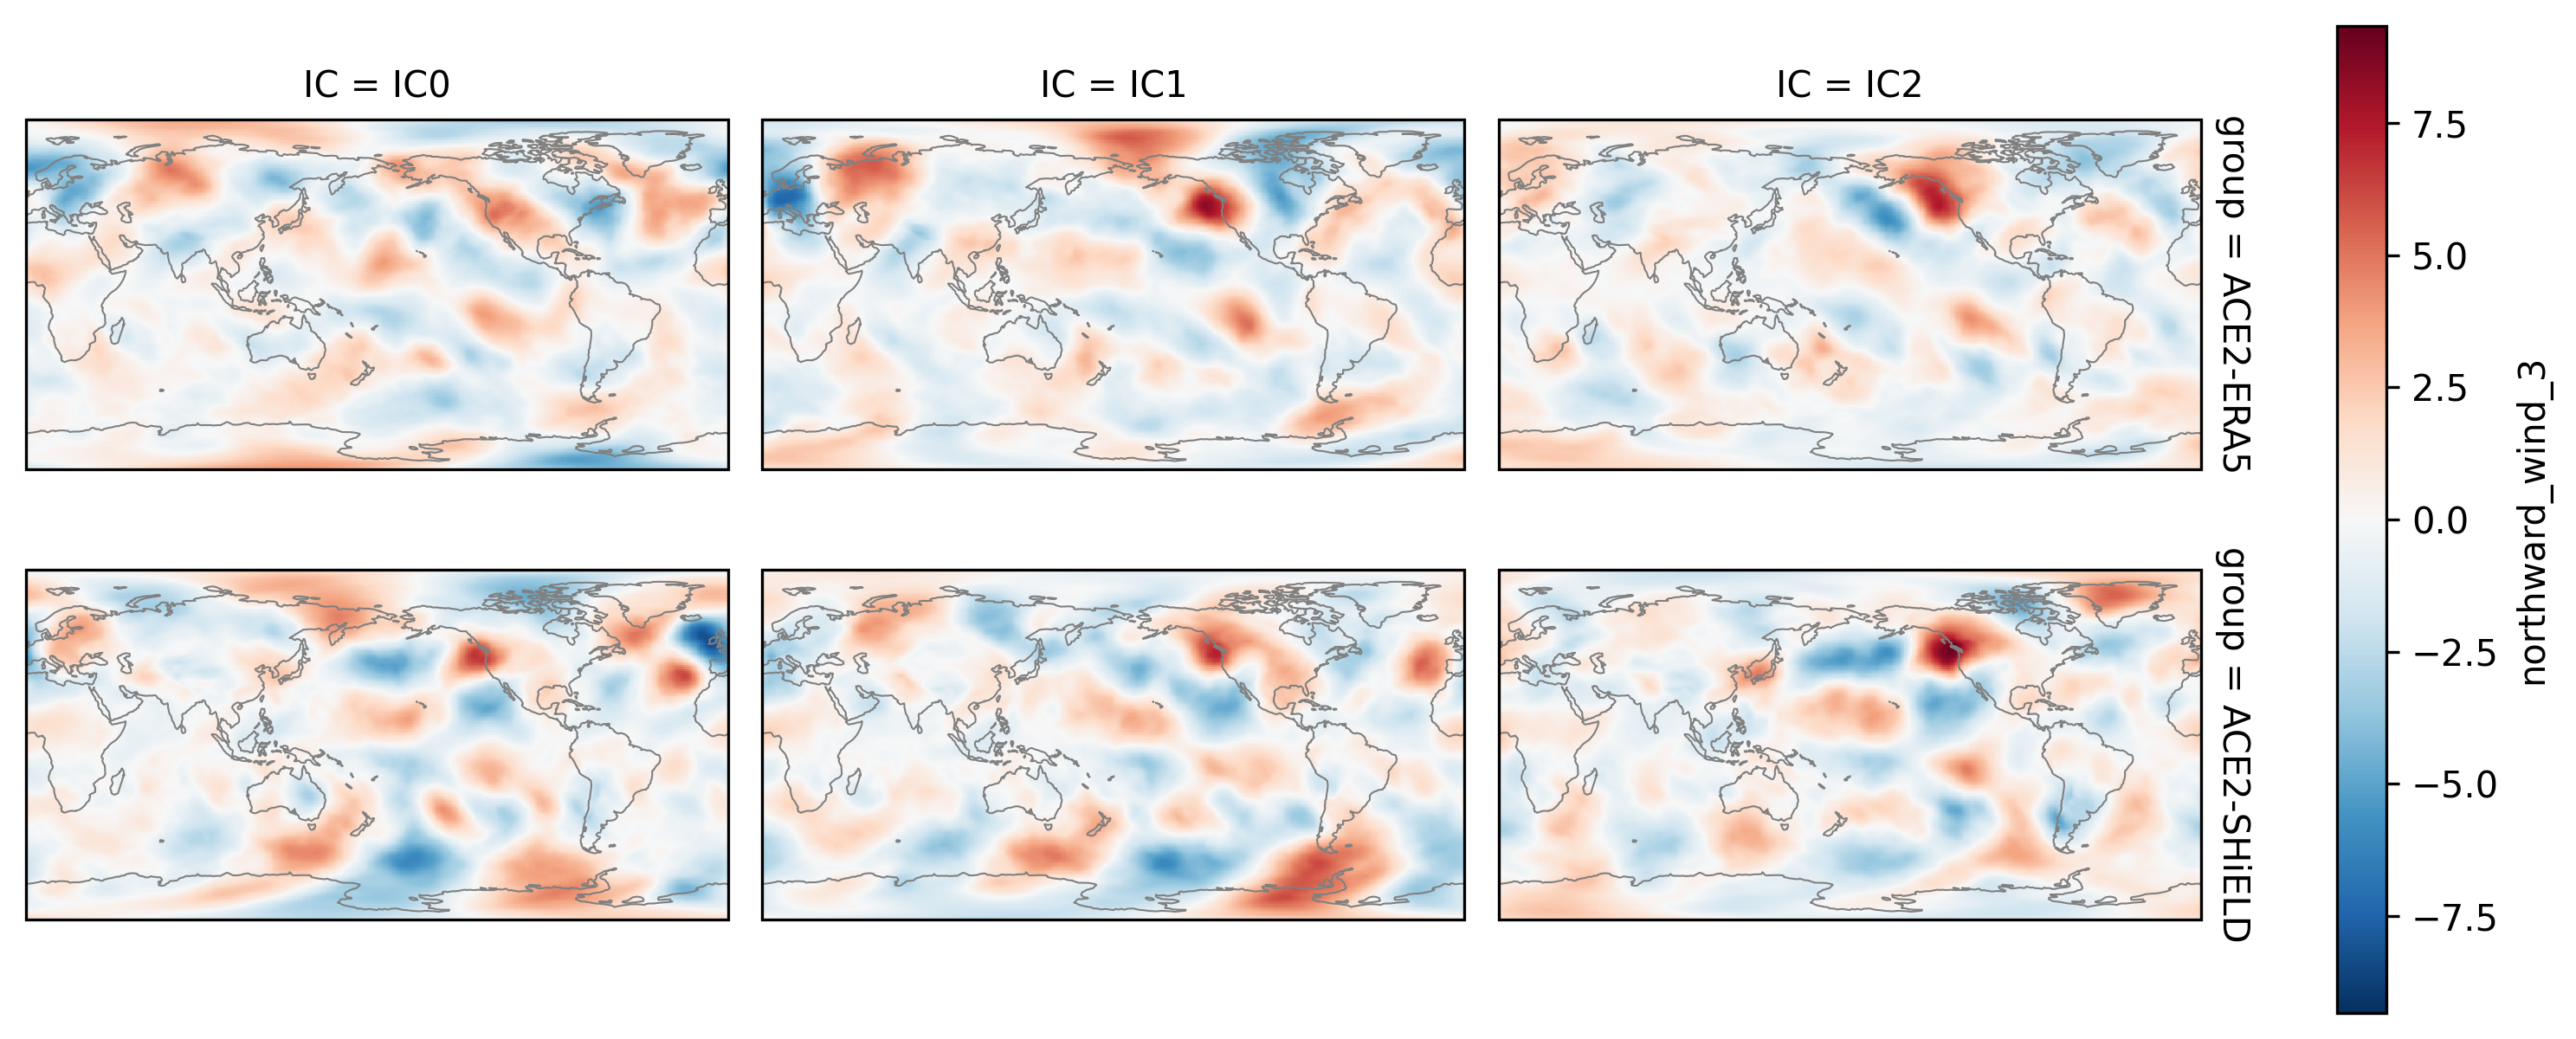

In [32]:
for var in diff.data_vars:
    if var == 'counts':
        continue
    plot_maps_ic(diff[var].sel(source='prediction'), **kwargs)